# Modeling and Simulation in Python

Chapter 17

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time')

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


Here's what the glucose time series looks like.

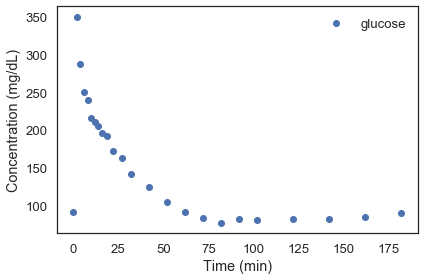

In [3]:
plot(data.glucose, 'bo', label='glucose')
decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

And the insulin time series.

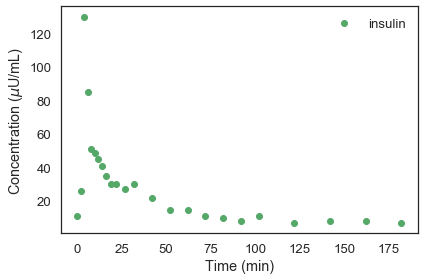

In [4]:
plot(data.insulin, 'go', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

For the book, I put them in a single figure, using `subplot`

Saving figure to file figs/chap17-fig01.pdf


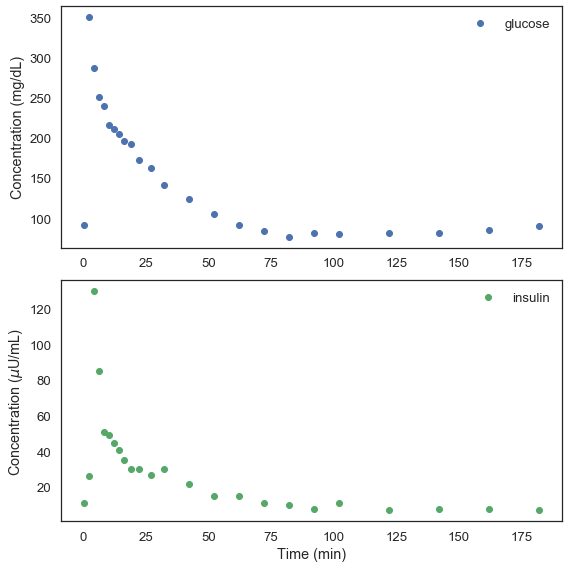

In [5]:
subplot(2, 1, 1)
plot(data.glucose, 'bo', label='glucose')
decorate(ylabel='Concentration (mg/dL)')

subplot(2, 1, 2)
plot(data.insulin, 'go', label='insulin')
decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

savefig('figs/chap17-fig01.pdf')

### Interpolation

We have measurements of insulin concentration at discrete points in time, but we need to estimate it at intervening points.  We'll use `interpolate`, which takes a `Series` and returns a function:

The return value from `interpolate` is a function.

In [6]:
I = interpolate(data.insulin)

<function modsim.modsim.interpolate.<locals>.wrapper(x)>

We can use the result, `I`, to estimate the insulin level at any point in time.

In [7]:
I(7)

68.0

`I` can also take an array of time and return an array of estimates:

In [8]:
t_0 = get_first_label(data)
t_end = get_last_label(data)
ts = linrange(t_0, t_end, endpoint=True)
I(ts)
type(ts)

numpy.ndarray

Here's what the interpolated values look like.

Saving figure to file figs/chap17-fig02.pdf


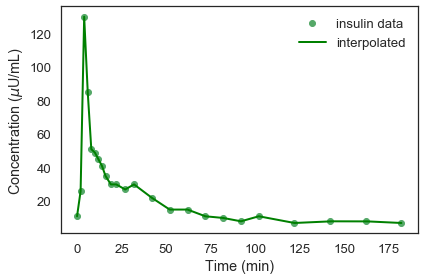

In [9]:
plot(data.insulin, 'go', label='insulin data')
plot(ts, I(ts), color='green', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

savefig('figs/chap17-fig02.pdf')

**Exercise:** [Read the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) of `scipy.interpolate.interp1d`.  Pass a keyword argument to `interpolate` to specify one of the other kinds of interpolation, and run the code again to see what it looks like. 

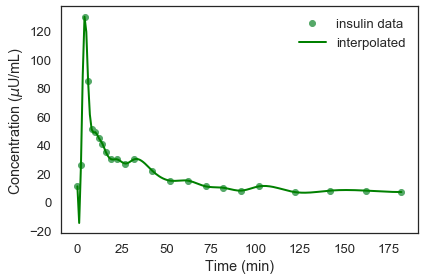

In [10]:
# Solution

I = interpolate(data.insulin, kind='cubic')
plot(data.insulin, 'go', label='insulin data')
plot(ts, I(ts), color='green', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration ($\mu$U/mL)')

**Exercise:** Interpolate the glucose data and generate a plot, similar to the previous one, that shows the data points and the interpolated curve evaluated at the time values in `ts`.

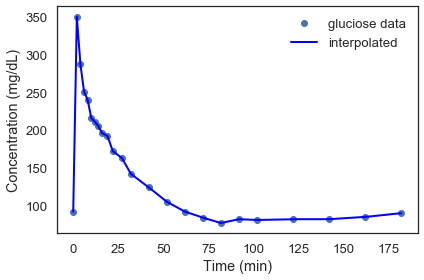

In [11]:
# Solution

G = interpolate(data.glucose)
plot(data.glucose, 'bo', label='gluciose data')
plot(ts, G(ts), color='blue', label='interpolated')

decorate(xlabel='Time (min)',
         ylabel='Concentration (mg/dL)')

### Under the hood

In [12]:
source_code(interpolate)

def interpolate(series, **options):
    """Creates an interpolation function.

    series: Series object
    options: any legal options to scipy.interpolate.interp1d

    returns: function that maps from the index of the series to values
    """
    if has_nan(series.index):
        msg = """The Series you passed to interpolate contains
                 NaN values in the index, which would result in
                 undefined behavior.  So I'm putting a stop to that."""
        raise ValueError(msg)

    if not is_strictly_increasing(series.index):
        msg = """The Series you passed to interpolate has an index
                 that is not strictly increasing, which would result in
                 undefined behavior.  So I'm putting a stop to that."""
        raise ValueError(msg)

    # make the interpolate function extrapolate past the ends of
    # the range, unless `options` already specifies a value for `fill_value`
    underride(options, fill_value='extrapolate')

    # call 